In [17]:
# https://www.kaggle.com/chekoduadarsh/pytorch-beginner-code-faster-rcnn

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re
import pydicom
import warnings

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import random
paddingSize= 0

warnings.filterwarnings("ignore")


DIR_INPUT = "/home/data/07_SSD4TB/public-datasets/vinbigdata-chest-xray-abnormalities-detection"
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.fillna(0, inplace=True)
train_df.loc[train_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

# FasterRCNN handles class_id==0 as the background.
train_df["class_id"] = train_df["class_id"] + 1
train_df.loc[train_df["class_id"] == 15, ["class_id"]] = 0

print("df Shape: "+str(train_df.shape))
print("No Of Classes: "+str(train_df["class_id"].nunique()))
train_df.sort_values(by='image_id').head(10)

df Shape: (67914, 8)
No Of Classes: 15


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
65515,000434271f63a053c4128a0ba6352c7f,No finding,0,R3,0.0,0.0,1.0,1.0
56742,000434271f63a053c4128a0ba6352c7f,No finding,0,R2,0.0,0.0,1.0,1.0
689,000434271f63a053c4128a0ba6352c7f,No finding,0,R6,0.0,0.0,1.0,1.0
62487,00053190460d56c53cc3e57321387478,No finding,0,R7,0.0,0.0,1.0,1.0
19324,00053190460d56c53cc3e57321387478,No finding,0,R2,0.0,0.0,1.0,1.0
11114,00053190460d56c53cc3e57321387478,No finding,0,R11,0.0,0.0,1.0,1.0
13648,0005e8e3701dfb1dd93d53e2ff537b6e,Nodule/Mass,9,R8,932.0,567.0,1197.0,896.0
15180,0005e8e3701dfb1dd93d53e2ff537b6e,Infiltration,7,R10,900.0,587.0,1205.0,888.0
16938,0005e8e3701dfb1dd93d53e2ff537b6e,Lung Opacity,8,R9,905.0,583.0,1203.0,890.0
664,0005e8e3701dfb1dd93d53e2ff537b6e,Lung Opacity,8,R10,900.0,587.0,1205.0,888.0


In [3]:
def label_to_name(id):
    id = int(id)
    id = id-1
    if id == 0:
        return "Aortic enlargement"
    if id == 1:
        return "Atelectasis"
    if id == 2:
        return "Calcification"
    if id == 3:
        return "Cardiomegaly"
    if id == 4:
        return "Consolidation"
    if id == 5:
        return "ILD"
    if id == 6:
        return "Infiltration"
    if id == 7:
        return "Lung Opacity"
    if id == 8:
        return "Nodule/Mass"
    if id == 9:
        return "Other lesion"
    if id == 10:
        return "Pleural effusion"
    if id == 11:
        return "Pleural thickening"
    if id == 12:
        return "Pneumothorax"
    if id == 13:
        return "Pulmonary fibrosis"
    else:
        return str(id)

In [4]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-10000:]# Tran and Validation Split 
train_ids = image_ids[:-10000]


valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

train_df["class_id"] = train_df["class_id"].apply(lambda x: x+1)
valid_df["class_id"] = valid_df["class_id"].apply(lambda x: x+1)

train_df.shape

(29986, 8)

In [5]:
#Clean

train_df['area'] = (train_df['x_max'] - train_df['x_min']) * (train_df['y_max'] - train_df['y_min'])
valid_df['area'] = (valid_df['x_max'] - valid_df['x_min']) * (valid_df['y_max'] - valid_df['y_min'])
train_df = train_df[train_df['area'] > 1]
valid_df = valid_df[valid_df['area'] > 1]

train_df = train_df[(train_df['class_id'] > 1) & (train_df['class_id'] < 15)]
valid_df = valid_df[(valid_df['class_id'] > 1) & (valid_df['class_id'] < 15)]


train_df = train_df.drop(['area'], axis = 1)
train_df.shape

(18740, 8)

In [6]:
# Thanks -  https://www.kaggle.com/pestipeti/
class VinBigDataset(Dataset): #Class to load Training Data
    
    def __init__(self, dataframe, image_dir, transforms=None,stat = 'Train'):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.stat = stat
        
    def __getitem__(self, index):
        if self.stat == 'Train':
            
            image_id = self.image_ids[index]
            records = self.df[(self.df['image_id'] == image_id)]
            records = records.reset_index(drop=True)

            dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")

            image = dicom.pixel_array

            if "PhotometricInterpretation" in dicom:
                if dicom.PhotometricInterpretation == "MONOCHROME1":
                    image = np.amax(image) - image

            intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
            slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

        
            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if records.loc[0, "class_id"] == 0:
                records = records.loc[[0], :]

            boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)
            labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

            # suppose all instances are not crowd
            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['image_id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd

            if self.transforms:
                sample = {
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                }
                sample = self.transforms(**sample)
                image = sample['image']

                target['boxes'] = torch.tensor(sample['bboxes']).type(torch.float32) ###

            if target["boxes"].shape[0] == 0:
                # Albumentation cuts the target (class 14, 1x1px in the corner)
                target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]])).type(torch.float32) ###
                target["area"] = torch.tensor([1.0], dtype=torch.float32)
                target["labels"] = torch.tensor([0], dtype=torch.int64)

            return image, target, image_ids
        
        else:
                   
            image_id = self.image_ids[index]
            records = self.df[(self.df['image_id'] == image_id)]
            records = records.reset_index(drop=True)

            dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")

            image = dicom.pixel_array

            intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
            slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0

            if slope != 1:
                image = slope * image.astype(np.float64)
                image = image.astype(np.int16)

            image += np.int16(intercept)        

            image = np.stack([image, image, image])
            image = image.astype('float32')
            image = image - image.min()
            image = image / image.max()
            image = image * 255.0
            image = image.transpose(1,2,0)

            if self.transforms:
                sample = {
                    'image': image,
                }
                sample = self.transforms(**sample)
                image = sample['image']

            return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [7]:
def dilation(img): # custom image processing function
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, tuple(np.random.randint(1, 6, 2)))
    img = cv2.dilate(img, kernel, iterations=1)
    return img

class Dilation(ImageOnlyTransform):
    def apply(self, img, **params):
        return dilation(img)

In [8]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),
        Dilation(),
        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ])

In [9]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [10]:
num_classes = 15 # 14 Classes + 1 background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VinBigDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = VinBigDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
# Create train and validate data loader
train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


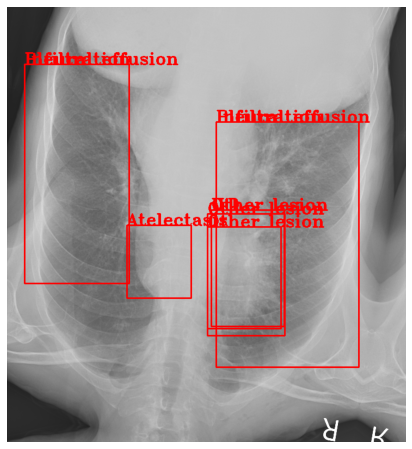

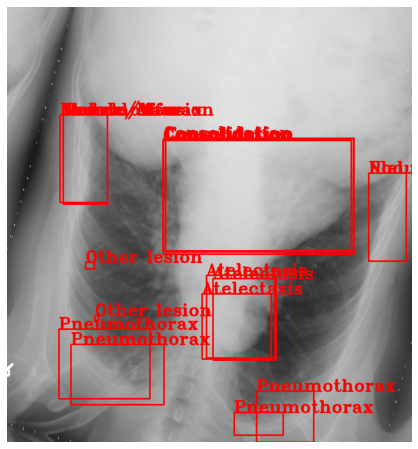

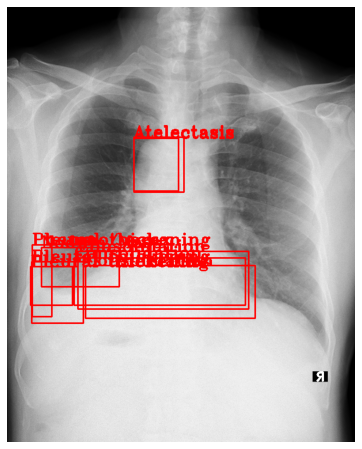

In [12]:
# Train dataset sample
images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

for number in random.sample([1,2,3],3):
    boxes = targets[number]['boxes'].cpu().numpy().astype(np.int32)
    img = images[number].permute(1,2,0).cpu().numpy()
    labels= targets[number]['labels'].cpu().numpy().astype(np.int32)
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for i in range(len(boxes)):
        img = cv2.rectangle(img,(boxes[i][0]+paddingSize,boxes[i][1]+paddingSize),(boxes[i][2]+paddingSize,boxes[i][3]+paddingSize),(255,0,0),2)
        #print(le.inverse_transform([labels[i]-1])[0])
        #print(label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])))
        img = cv2.putText(img, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])), cv2.FONT_HERSHEY_TRIPLEX,1, (255,0,0), 2, cv2.LINE_AA)

    ax.set_axis_off()
    ax.imshow(img)

In [13]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [14]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs =  2 #Low epoch to save GPU time

In [16]:
loss_hist = Averager()
itr = 1
lossHistoryiter = []
lossHistoryepoch = []

import time
start = time.time()

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)  
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)
        lossHistoryiter.append(loss_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
    lossHistoryepoch.append(loss_hist.value)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time taken to Train the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Iteration #50 loss: 1.2575032711029053
Iteration #100 loss: 1.2225394248962402
Iteration #150 loss: 0.8067507147789001
Iteration #200 loss: 0.8014839887619019
Iteration #250 loss: 0.6363880634307861
Epoch #0 loss: 0.9324903226848962
Iteration #300 loss: 0.6622176170349121
Iteration #350 loss: 0.894905686378479
Iteration #400 loss: 0.7506977319717407
Iteration #450 loss: 0.8648357391357422
Iteration #500 loss: 1.0785880088806152
Iteration #550 loss: 0.8681511878967285
Epoch #1 loss: 0.8376117534395577
Time taken to Train the model :00:16:53.72


In [81]:
# this is old stuff

In [ ]:
# https://www.kaggle.com/pestipeti/vinbigdata-fasterrcnn-pytorch-train

In [76]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.model_selection import train_test_split
from sklearn import model_selection

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import bbox_visualizer as bbv

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from glob import glob
from skimage import exposure

import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
import torchvision
#from torchvision.models.detection import retinanet_resnet50_fpn
#from torchvision.models.detection.retinanet import RetinaNet

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import warnings
from zipfile import ZipFile

import matplotlib.patches as patches

warnings.filterwarnings('ignore')

In [2]:
def extract_zip(fzip, fnew=None):
    with ZipFile(fzip, 'r') as zip:  # ZipFile(fzip, 'r') as zip:
        print('Extracting all the train files now...')
        zip.extractall(fnew)
        print('Done!')

In [3]:
#_from = "/home/data/07_SSD4TB/public-datasets/vinbigdata-chest-xray-abnormalities-detection/vinbigdata-chest-xray-abnormalities-detection.zip"

DIR_INPUT = "/home/data/07_SSD4TB/public-datasets/vinbigdata-chest-xray-abnormalities-detection"
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [4]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.fillna(0, inplace=True)
train_df.loc[train_df["class_id"] == 14, ['x_max', 'y_max']] = 1.0

# FasterRCNN handles class_id==0 as the background.
train_df["class_id"] = train_df["class_id"] + 1
train_df.loc[train_df["class_id"] == 15, ["class_id"]] = 0

train_df.shape

(67914, 8)

In [5]:
train_df.sort_values(by='image_id').head(20)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
65515,000434271f63a053c4128a0ba6352c7f,No finding,0,R3,0.0,0.0,1.0,1.0
56742,000434271f63a053c4128a0ba6352c7f,No finding,0,R2,0.0,0.0,1.0,1.0
689,000434271f63a053c4128a0ba6352c7f,No finding,0,R6,0.0,0.0,1.0,1.0
62487,00053190460d56c53cc3e57321387478,No finding,0,R7,0.0,0.0,1.0,1.0
19324,00053190460d56c53cc3e57321387478,No finding,0,R2,0.0,0.0,1.0,1.0
11114,00053190460d56c53cc3e57321387478,No finding,0,R11,0.0,0.0,1.0,1.0
13648,0005e8e3701dfb1dd93d53e2ff537b6e,Nodule/Mass,9,R8,932.0,567.0,1197.0,896.0
15180,0005e8e3701dfb1dd93d53e2ff537b6e,Infiltration,7,R10,900.0,587.0,1205.0,888.0
16938,0005e8e3701dfb1dd93d53e2ff537b6e,Lung Opacity,8,R9,905.0,583.0,1203.0,890.0
664,0005e8e3701dfb1dd93d53e2ff537b6e,Lung Opacity,8,R10,900.0,587.0,1205.0,888.0


In [6]:
train_df["class_id"].nunique()

15

In [7]:
sample_id = "000434271f63a053c4128a0ba6352c7f"

dicom = pydicom.dcmread(f"{DIR_TRAIN}/{sample_id}.dicom")
dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 000434271f63a053c4128a0ba6352c7f
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: ''
(0002, 0016) Source Application Entity Title     AE: 'VITREA1'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'O'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME1'
(0028, 0010) Rows                                US: 2836
(0028, 0011) Columns                             US: 2336
(0028, 0030) Pixel Spacing            

In [8]:
image = dicom.pixel_array * dicom.RescaleSlope + dicom.RescaleIntercept

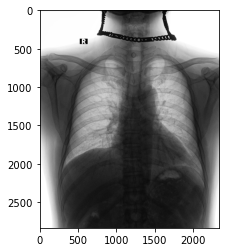

In [9]:
plt.imshow(image, cmap='gray')

In [10]:
dicom

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 156
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 000434271f63a053c4128a0ba6352c7f
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: ''
(0002, 0016) Source Application Entity Title     AE: 'VITREA1'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'O'
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME1'
(0028, 0010) Rows                                US: 2836
(0028, 0011) Columns                             US: 2336
(0028, 0030) Pixel Spacing            

In [11]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-3000:]
train_ids = image_ids[:-3000]

In [12]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [13]:
valid_df.shape, train_df.shape

((9590, 8), (58324, 8))

In [45]:
class VinBigDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        records = records.reset_index(drop=True)

        dicom = pydicom.dcmread(f"{self.image_dir}/{image_id}.dicom")
        
        image = dicom.pixel_array
        
        if "PhotometricInterpretation" in dicom:
            if dicom.PhotometricInterpretation == "MONOCHROME1":
                image = np.amax(image) - image
        
        intercept = dicom.RescaleIntercept if "RescaleIntercept" in dicom else 0.0
        slope = dicom.RescaleSlope if "RescaleSlope" in dicom else 1.0
        
        if slope != 1:
            image = slope * image.astype(np.float64)
            image = image.astype(np.int16)
            
        image += np.int16(intercept)        
        
        image = np.stack([image, image, image])
        image = image.astype('float32')
        image = image - image.min()
        image = image / image.max()
        image = image * 255.0
        image = image.transpose(1,2,0)
       
        if records.loc[0, "class_id"] == 0:
            records = records.loc[[0], :]
        
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        labels = torch.tensor(records["class_id"].values, dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.tensor(sample['bboxes']).type(torch.float32) ###

        if target["boxes"].shape[0] == 0:
            # Albumentation cuts the target (class 14, 1x1px in the corner)
            target["boxes"] = torch.from_numpy(np.array([[0.0, 0.0, 1.0, 1.0]])).type(torch.float32) ###
            target["area"] = torch.tensor([1.0], dtype=torch.float32)
            target["labels"] = torch.tensor([0], dtype=torch.int64)
            
        return image, target
    
    def __len__(self):
        return self.image_ids.shape[0]

In [46]:
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=45, p=0.25),
        A.LongestMaxSize(max_size=800, p=1.0),

        # FasterRCNN will normalize.
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [47]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [48]:
num_classes = 15

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [49]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VinBigDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = VinBigDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [50]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [51]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [52]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

num_epochs = 12

In [53]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        
        #losses = losses.type(torch.cuda.FloatTensor) #losses.type(torch.float32)
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 100 == 0:
            print(f"Iteration #{itr} loss: {loss_hist.value}")

        itr += 1
        
        # !!!REMOVE THIS!!!
        break
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")   
    # print("Saving epoch's state...")
    # torch.save(model.state_dict(), f"model_state_epoch_{epoch}.pth")

Epoch #0 loss: 4.51558780670166
Epoch #1 loss: 4.5096282958984375
Epoch #2 loss: 1.3775354623794556
Epoch #3 loss: 1.8634437322616577
Epoch #4 loss: 1.7982803583145142
Epoch #5 loss: 2.341111660003662
Epoch #6 loss: 1.2996253967285156
Epoch #7 loss: 1.3641797304153442
Epoch #8 loss: 0.8993459343910217
Epoch #9 loss: 0.5433467626571655
Epoch #10 loss: 1.2326743602752686
Epoch #11 loss: 0.83771812915802


In [54]:
images, targets = next(iter(valid_data_loader))

In [55]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [56]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [57]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

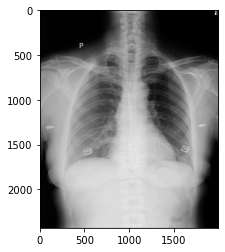

In [77]:
fig, ax = plt.subplots()

# Display the image
ax.imshow(sample)

# Create a Rectangle patch
rect = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

In [79]:
box[0]

0